In [1]:
# データ元: https://www.kaggle.com/puneet6060/intel-image-classification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, os.path
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [2]:
# Step 2: Define transforms  (画像をコンピューターが分かりやすいように変更するための設定をする)
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
CFG = {'batch':32, 'epoch':2}

In [4]:
train_data = datasets.ImageFolder("C:\\Users\\shota\\Documents\\Data\\Kaggle\\lesson_image_data\\Intel_Image_Classification\\seg_train\\seg_train\\", transform=transformations)
val_data = datasets.ImageFolder("C:\\Users\\shota\\Documents\\Data\\Kaggle\\lesson_image_data\\Intel_Image_Classification\\seg_test\\seg_test\\", transform=transformations)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG['batch'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=CFG['batch'], shuffle=True)

In [5]:
# Step 4: Creating our model
# 転移学習（Transfer Learning)
model = models.densenet161(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

In [6]:
# 機械学習で判定するラベルの数を確かめるために、ファイルではなくディレクトリのみを抽出して数を出した
DATA_PATH = 'C:\\Users\\shota\\Documents\\Data\\Kaggle\\lesson_image_data\\Intel_Image_Classification\\seg_train\\seg_train'
len([name for name in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, name))])   #条件を課してリストに追加していったものを数えている

6

In [7]:
os.listdir(DATA_PATH)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [8]:
classifier_input = model.classifier.in_features
num_labels = len([name for name in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, name))])
classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           nn.LogSoftmax(dim=1))
model.classifier = classifier

In [9]:
classifier_input

2208

In [10]:
# Step 5: Training and Evaluating our model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [11]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters())

In [12]:
epochs = CFG['epoch']
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(labels)
        optimizer.zero_grad()
        output = model.forward(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*inputs.size(0)
        counter += 1
        print(counter, '/', len(train_loader))
    
    model.eval()
    counter=0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model.forward(inputs)
            valloss = criterion(output, labels)
            val_loss = valloss.item()*inputs.size(0)
            output = torch.exp(output)
            top_p, top_class = output.topk(1, dim=1)    # top-k accuracyというのは、モデルが予測した分類のうち、確率の高いもの上位k位までに正解がある確率
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            counter += 1
            print(counter, '/', len(val_loader))
            
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    print('Accuracy:', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

1 / 439
2 / 439
3 / 439
4 / 439
5 / 439
6 / 439
7 / 439
8 / 439
9 / 439
10 / 439
11 / 439
12 / 439
13 / 439
14 / 439
15 / 439
16 / 439
17 / 439
18 / 439
19 / 439
20 / 439
21 / 439
22 / 439
23 / 439
24 / 439
25 / 439
26 / 439
27 / 439
28 / 439
29 / 439
30 / 439
31 / 439
32 / 439
33 / 439
34 / 439
35 / 439
36 / 439
37 / 439
38 / 439
39 / 439
40 / 439
41 / 439
42 / 439
43 / 439
44 / 439
45 / 439
46 / 439
47 / 439
48 / 439
49 / 439
50 / 439
51 / 439
52 / 439
53 / 439
54 / 439
55 / 439
56 / 439
57 / 439
58 / 439
59 / 439
60 / 439
61 / 439
62 / 439
63 / 439
64 / 439
65 / 439
66 / 439
67 / 439
68 / 439
69 / 439
70 / 439
71 / 439
72 / 439
73 / 439
74 / 439
75 / 439
76 / 439
77 / 439
78 / 439
79 / 439
80 / 439
81 / 439
82 / 439
83 / 439
84 / 439
85 / 439
86 / 439
87 / 439
88 / 439
89 / 439
90 / 439
91 / 439
92 / 439
93 / 439
94 / 439
95 / 439
96 / 439
97 / 439
98 / 439
99 / 439
100 / 439
101 / 439
102 / 439
103 / 439
104 / 439
105 / 439
106 / 439
107 / 439
108 / 439
109 / 439
110 / 439
111 / 43

In [13]:
len(train_loader),  len(train_loader.dataset)

(439, 14034)

In [14]:
len(train_loader) * CFG['batch']   #よって、train_loaderの数はバッチごと、train_loader.datasetはデータすべての数

14048

In [15]:
inputs

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008],
          ...,
          [ 0.3823,  0.0398,  0.6221,  ...,  1.7180,  1.4783,  1.4612],
          [ 0.5707,  1.0331,  1.3927,  ...,  1.5982,  1.2214,  1.3413],
          [ 0.9988,  1.5468,  1.7694,  ...,  1.5810,  1.2214,  1.4098]],

         [[-0.4951, -0.4951, -0.4951,  ..., -0.5651, -0.5651, -0.5651],
          [-0.4951, -0.4951, -0.4951,  ..., -0.5476, -0.5476, -0.5476],
          [-0.4951, -0.4951, -0.4951,  ..., -0.5476, -0.5476, -0.5476],
          ...,
          [ 0.0126, -0.3025,  0.2927,  ...,  1.2206,  0.9580,  0.9580],
          [ 0.2052,  0.6604,  1.0455,  ...,  1.0980,  0.7129,  0.8354],
          [ 0.6429,  1.1856,  1.4132,  ...,  1.1155,  0.7479,  0.9405]],

         [[ 1.1237,  1.1237,  1.1237,  ...,  1.2282,  1.2282,  1.2282],
          [ 1.1237,  1.1237,  

In [16]:
inputs.shape      #順番としてはおそらく[データ数, カラーチャネル数, 高さ, 幅]

torch.Size([24, 3, 224, 224])

In [17]:
inputs.shape[0],    inputs.size(0)

(24, 24)

In [18]:
loss.item(),   loss        #item()の意味

(0.05111933872103691, tensor(0.0511, grad_fn=<NllLossBackward>))

In [19]:
# Step 5: Actually Using our model
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [29]:
def process_image(image_path):
    img = Image.open(image_path)
    width, height = img.size
    img = img.resize((255, int(255*height/width)) if width < height else (int(255*width/height), 255))
    width, height = img.size
    
     # 224×224部分をくりぬくため、設定する(画像の位置番号は左上が最初)
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))     #実際に切り抜く(時計でいう9時から時計回りの順番)
    
    img = np.array(img)
    
    img = img.transpose(2,0,1)     # HWC → CHW    (推論エンジンのフォーマットはCHW型のため変換が必要)
    img = img/255
    
    # transposeでcolorのchannelを最初に持ってきたことによって、以下のように標準化することができる
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # array型からtorch形に変換
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [23]:
def predict(image, model):
    output = model.forward(image)
    output = torch.exp(output)
    probs, classes = output.topk(1, dim=1)      
    return probs.item(), classes.item()         #  正解してる確率とダミークラスを返す

In [25]:
def show_image(image):
    #Convert image to numpy
    image = image.numpy()
    
    #標準化したもの元に戻す
    image[0] = image[0]*0.226 + 0.445
    
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model is 99.97052550315857 % certain that the image has a predicted class of  0


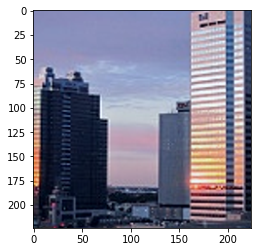

In [30]:
# Process Image
image = process_image('C:\\Users\\shota\\Documents\\Data\\Kaggle\\lesson_image_data\\Intel_Image_Classification\\seg_pred\\seg_pred\\5.jpg')
# Give image to model to predict output
top_prob, top_class = predict(image, model)
# Show the image
show_image(image)
# Print the results
print("The model is", top_prob*100, "% certain that the image has a predicted class of ", top_class)